In [ ]:
!pip install --upgrade matplotlib > None

In [ ]:
!pip install seaborn > None

In [116]:
!pip install numpy scipy scikit-learn > None

In [118]:
!pip install shap > None

In [119]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score, fbeta_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier


# **Введение**

Учебное исследование выполняется на наборе данных с Kaggle.com: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

Впервые, набор данных был представлен в следующем исследовании:

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

Набор данных представляет собой физико-химические характеристики красного вина:
1. фиксированная кислотность
2. летучая кислотность
3. лимонная кислота
4. остаточный сахар
5. хлориды
6. свободный диоксид серы
7. общий диоксид серы
8. плотность
9. pH
10. сульфаты
11. спирт 
 
Целевая величина - экспертная оценка качества вина.




# **Придумаем искуственную бизнес-задачу:**

Необходимо на основе химических данных выделять:
- "хорошее" вино с оценкой более 6.5 для отправки в фирменные магазины
- "плохое" вино с оценкой ниже 4.5 - брак, отправляем на уксус:)
- все остальное вино называем "посредственным" и отправляем в супермаркеты

Для формирования требований к качеству модели введем следующие условия, к которым мы должны стремиться при разработке:

- в фирменные магазины должно поступать только "хорошее" вино, при этом мы не должны отсеивать более 20% от всего "хорошего" вина
- "плохое" вино не должно поступать в магазины, при этом количество выявленного моделью "плохого" вина не должно превышать его истинное количество более чем на 50%.

Не уверен, что цель будет достигнута, но будем к ней стремиться


# **1.Выбрать и обосновать метрику для измерения качества.**

Сначала придумаем как решать задачу.

Будем обучать два классификатора по принципу One-vs-All:

- для первого 1 - хорошее вино, 0 - все остальное
- для второго 1 - плохое вино, 0 - все остальное

Для первого - стараемся максимизировать Precision, при этом Recall не должен быть меньше 0.8. Качество классификатора оценим Fbeta мерой c beta = 0.5.

Для второго - стараемся максимизировать Recall, при этом Precision не должен быть меньше 0.67, Качество классификатора оценим Fbeta мерой c beta = 2.

Для оценки качества "полной" модели усредним Fbeta-меру, посчитанную для каждого из классификаторов.

Не факт, что идея хорошая, но мы же учимся


# **2.Провести EDA на своих данных**

Загрузим данные и посмотрим на них.

In [121]:
path = 'WineQT.csv'
data = pd.read_csv(path, index_col='Id')
df = data.copy()
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Кажется, все столбцы численные - отлично.

Теперь посмотрим на общие характеристики датасета: размер, типы данных, пустые строки, описание численных данных.

In [122]:
df.shape

(1143, 12)

In [123]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [124]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [125]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Действительно, все данные числовые, пропусков нет. Судя по процентилям целевой переменной данные несбалансированы по классам. Большую часть составляют "посредственные" вина. Проверим это чуть позже.

Сейчас посмотрим на количество уникальных значений в строках и проверим наличие повторяющихся строк.

In [126]:
df.nunique()

fixed acidity            91
volatile acidity        135
citric acid              77
residual sugar           80
chlorides               131
free sulfur dioxide      53
total sulfur dioxide    138
density                 388
pH                       87
sulphates                89
alcohol                  61
quality                   6
dtype: int64

In [127]:
df.value_counts()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density  pH    sulphates  alcohol  quality
7.5            0.510             0.02         1.7             0.084      13.0                 31.0                  0.99538  3.36  0.54       10.5     6          4
6.7            0.460             0.24         1.7             0.077      18.0                 34.0                  0.99480  3.39  0.60       10.6     6          4
9.3            0.360             0.39         1.5             0.080      41.0                 55.0                  0.99652  3.47  0.73       10.9     6          3
9.9            0.540             0.45         2.3             0.071      16.0                 40.0                  0.99910  3.39  0.62       9.4      5          3
6.0            0.500             0.00         1.4             0.057      15.0                 26.0                  0.99448  3.36  0.45       9.5      5          3
                     

В данных есть повторяющиеся строки. Около 10 % от всего датасета. Избавимся от них. 

In [128]:
df_uniq = pd.DataFrame([list(tup) for tup in df.value_counts().index], columns=df.columns)
df_uniq.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000
mean,8.288507,0.533541,0.268802,2.524411,0.087187,15.648821,46.325639,0.996700,3.311503,0.656817,10.452456,5.641454
std,1.741324,0.183167,0.196229,1.314850,0.048506,10.176525,33.123533,0.001916,0.157775,0.167542,1.095064,0.811744
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,21.000000,0.995572,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,38.000000,0.996665,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.645000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997827,3.400000,0.720000,11.200000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Посмотрим на отношения каждого из признаком с целевой переменной.

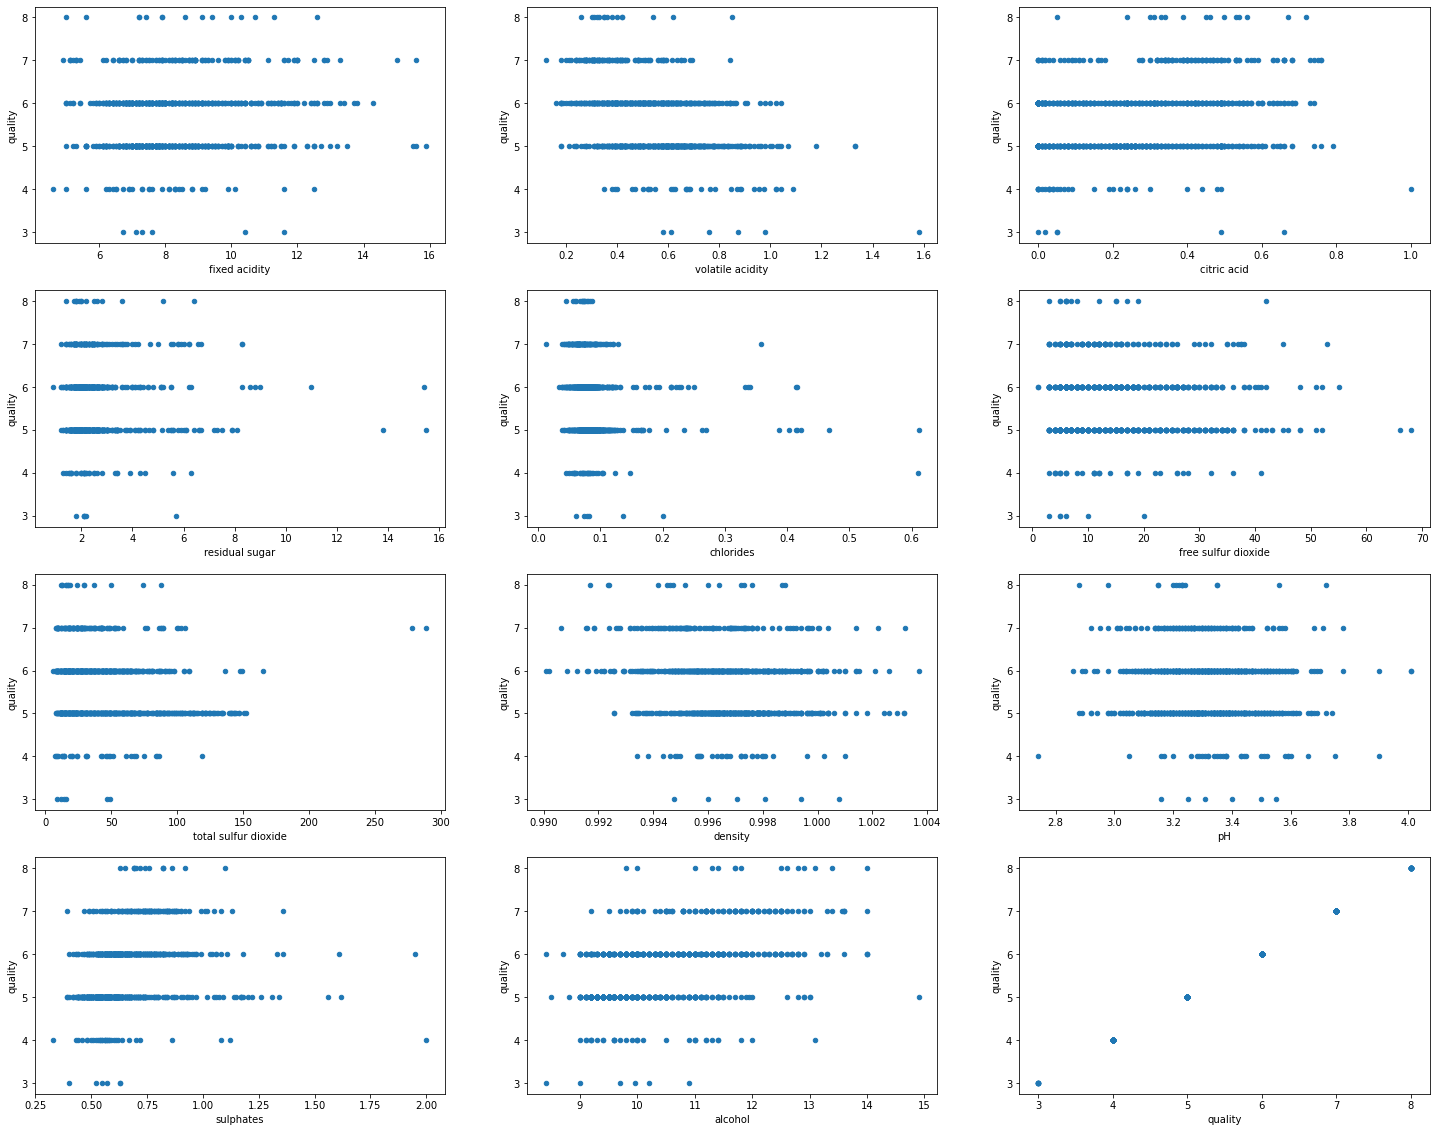

In [129]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (25, 20))
for idx, feature in enumerate(df_uniq.columns):
    df_uniq.plot(feature, 'quality', subplots = True, kind = "scatter", ax = axes[idx // 3, idx % 3])

Явных зависимостей не наблюдается.

Разделим вино на "категории" и помотрим на распределение по каждому из признаков.

In [130]:
target = []
for qual in df_uniq['quality']:
  if qual > 6:
    targ = 'good'
  elif qual < 5:
    targ = 'bad'
  else:
    targ = 'satisfied'
  target.append(targ)
df_mod = df_uniq.iloc[:,0:11]
df_mod['target'] = target
features = df_mod.columns[df_mod.columns != 'target']
#print(features)

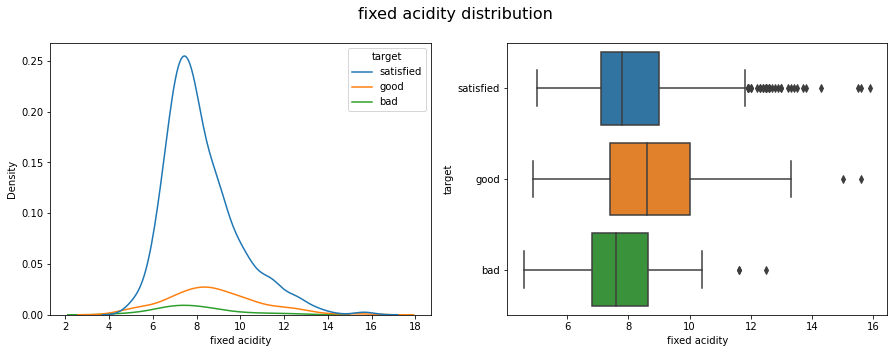

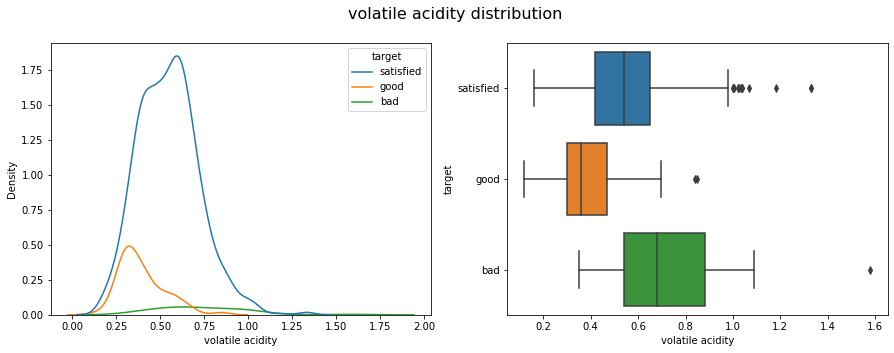

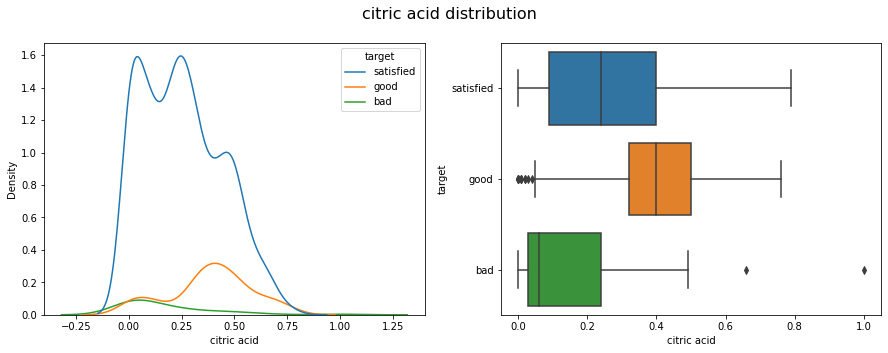

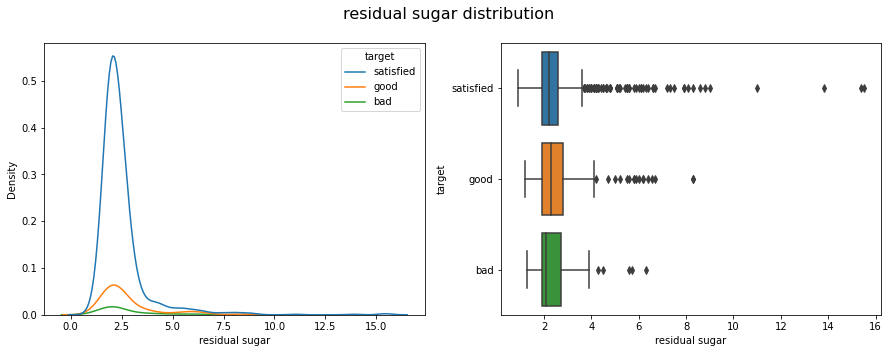

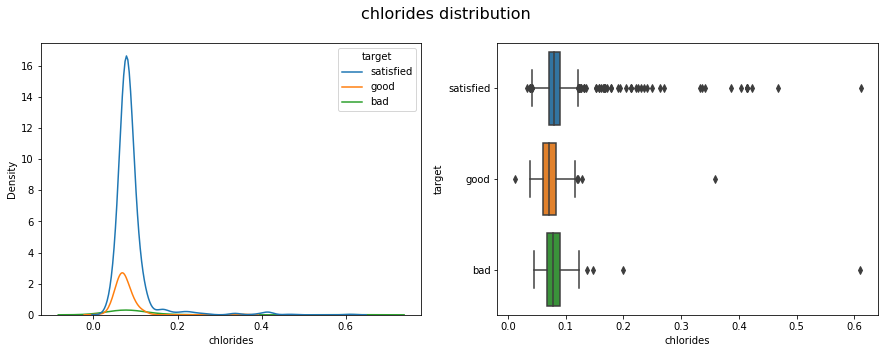

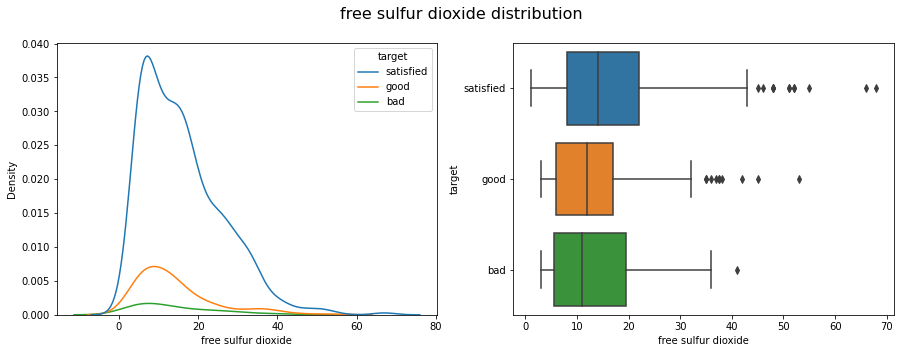

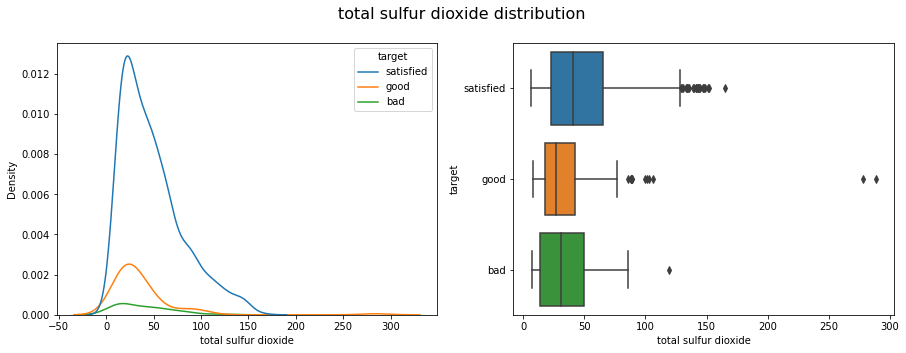

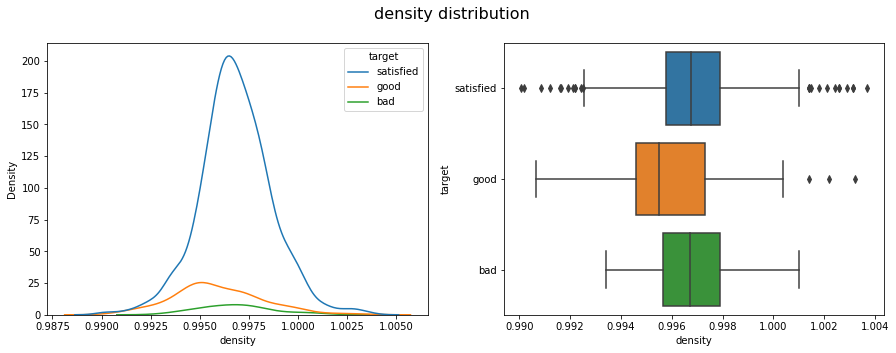

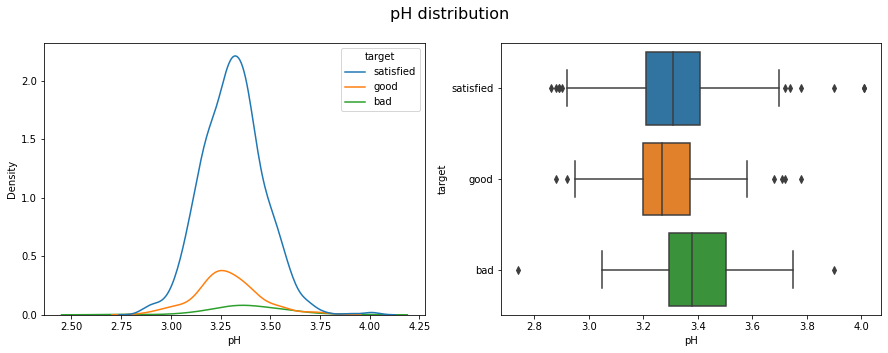

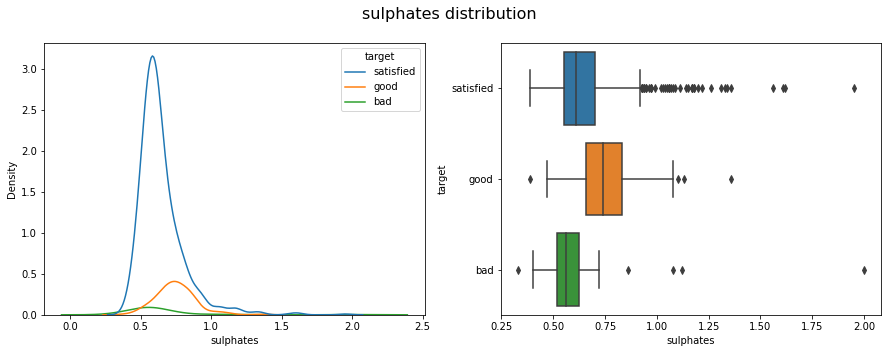

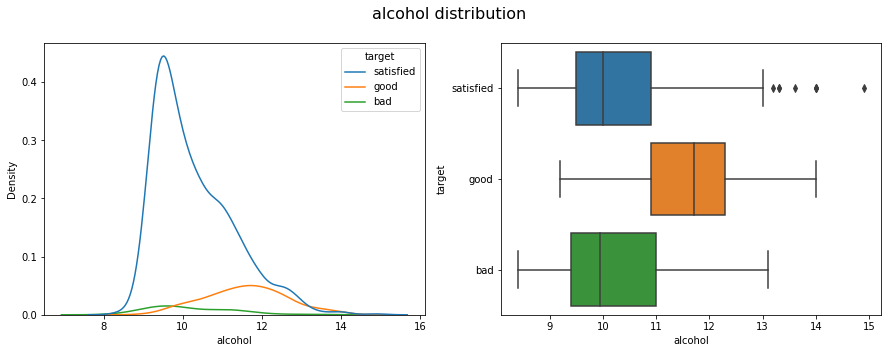

In [131]:
for feature in features:
        fig, axes = plt.subplots(1, 2, figsize=[15, 5])
        fig.suptitle(f'{feature} distribution', fontsize=16)
        sns.kdeplot(data=df_mod, x=feature, hue='target', ax=axes[0])
        sns.boxplot(data=df_mod.astype({'target': str}), y='target', x=feature, ax=axes[1])

Часть распределений "скошены" в область низких значений признаков. Есть выбросы в сторону высоких значений признаков. Тем не менее, явных аномалий в признаках нет. Решение об удалении этих данных на этом этапе принимать не стоит, но можно будет попробовать при "дизайне" модели, если возникнет необходимость.

Явно есть дисбаланс в целевой переменной.

Посмотрим на распределение целевой переменной.


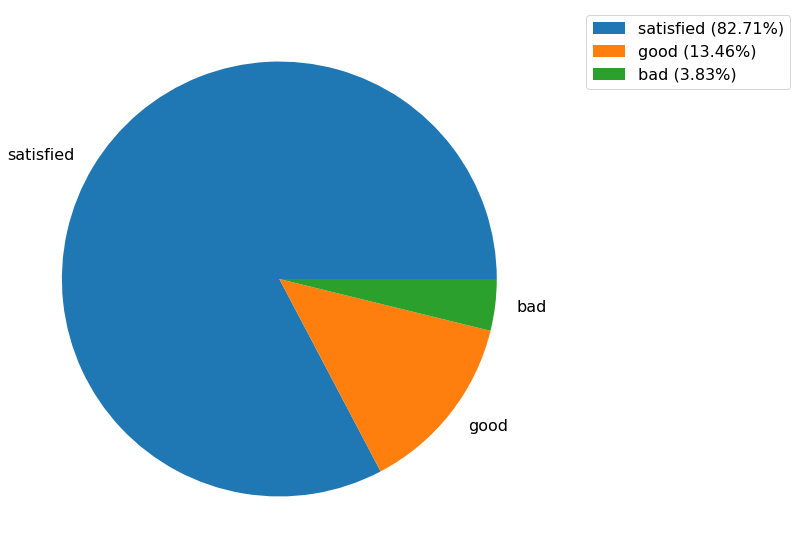

In [132]:
plt.figure(figsize = (10,10))
fig.suptitle('Target distribution', fontsize=16)
target_counts = df_mod['target'].value_counts()
plt.pie(target_counts, labels=target_counts.index, textprops={'fontsize': 16})
legend_entries = [f'{label} ({count/len(df_mod)*100:.2f}%)' for label, count in target_counts.items()]
plt.legend(legend_entries, bbox_to_anchor=(1.05, 1), loc='best', fontsize=16)
plt.show()

Действительно, более 80% датасета относятся к "посредственным" образцам.

Это надо будет учесть при разбиении на тестовую и тренирововчную выборку, по возможности это распределение нужно сохранить.

Посмотрим на матрицу корреляции.

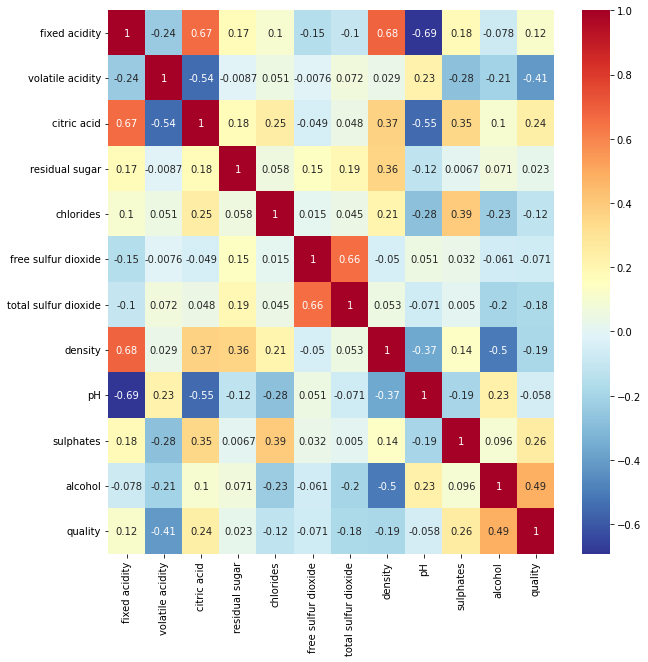

In [133]:
plt.figure(figsize = (10,10))
sns.heatmap(df_uniq.corr(), cmap = "RdYlBu_r", annot = True)

Выведем корелляции целевой переменной с признаками.

Наибольшая положительная корреляция с уровенм алкоголя. Это объяснимо, уровень алкоголя при естественном брожении зависит от уровня сахара в сырье, который в свою очередь повышается в зависимости от зрелости винограда и климата - чем более спелый виноград и благоприятный климат - тем выше.

Наибольшая отрицательная корреляция с летучими кислотами. Это тоже логично - при высоком уровне они дают неприятный вкус. В виноделии их количество сознательно ограничивают.



In [134]:
corr_matrix = df_uniq.corr()
print(corr_matrix['quality'].sort_values(ascending=False),'\n')

quality                 1.000000
alcohol                 0.485953
sulphates               0.257519
citric acid             0.241565
fixed acidity           0.115826
residual sugar          0.022718
pH                     -0.057592
free sulfur dioxide    -0.071083
chlorides              -0.122214
total sulfur dioxide   -0.182214
density                -0.185187
volatile acidity       -0.409340
Name: quality, dtype: float64 



Выведем наиболее скореллированные признаки.

In [135]:
# Threshold for correlation value
threshold = 0.5

# Get the high-correlated pairs of columns, excluding auto-correlations
corr_pairs = (
    corr_matrix[abs(corr_matrix) > threshold][corr_matrix != 1.0]
).unstack().dropna().to_dict()

# Remove duplicate pairs and create a dataframe with unique pairs
unique_corr_pairs = pd.DataFrame(
    list(
        set([(tuple(sorted(key)), corr_pairs[key]) for key in corr_pairs])
    ), columns=['pair', 'corr']
)

# Show the unique pairs and their correlation value
unique_corr_pairs.sort_values(by=['corr'], ascending=False)


,pair,corr
5,"(density, fixed acidity)",0.683120
3,"(citric acid, fixed acidity)",0.668178
4,"(free sulfur dioxide, total sulfur dioxide)",0.661089
0,"(alcohol, density)",-0.504748
1,"(citric acid, volatile acidity)",-0.542459
2,"(citric acid, pH)",-0.553370
6,"(fixed acidity, pH)",-0.692597


Тут объяснимы отрицательные корреляции между кислотами и Ph. Показатель Ph определяет общую кислотность вина, чем ниже, тем меньше килоты.
Также легко объяснима положительная корреляция между общим диокссидом серы и свободным диоксидом серы - чем больше консерванта положили, тем больше растворилось.
Остальная "химия" не настолько очевидна для объяснения.

Применим к данным метод главных компонент

In [136]:
target = []
for qual in df_uniq['quality']:
  if qual > 6:
    targ = 0
  elif qual < 5:
    targ = 2
  else:
    targ = 1
  target.append(targ)
df_mod_new = df_uniq.iloc[:,0:11]
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_mod_new)

In [137]:
model = PCA(n_components = 2)
model.fit(df_scaled)
pca_coords = model.transform(df_scaled)

df_to_draw = pd.DataFrame({
    'class': target,
    'pca1': pca_coords[:, 0],
    'pca2': pca_coords[:, 1]
})
colors = ['b', 'r', 'k' , 'g']

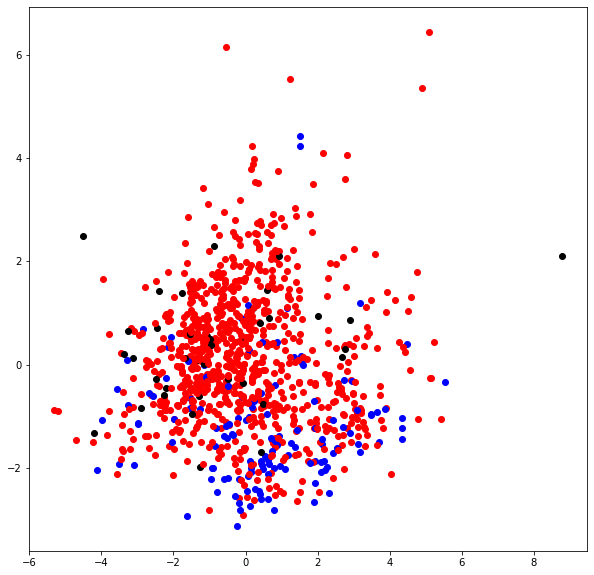

In [138]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
for f in df_to_draw.iterrows():
  ax.scatter(f[1]['pca1'], f[1]['pca2'], c = colors[int(f[1]['class'])])
  
plt.show()

In [139]:
model = PCA(n_components = 3)
model.fit(df_scaled)
pca_coords = model.transform(df_scaled)

df_to_draw = pd.DataFrame({
    'class': target,
    'pca1': pca_coords[:, 0],
    'pca2': pca_coords[:, 1],
    'pca3': pca_coords[:, 2]
})
colors = ['b', 'r', 'k' , 'g']

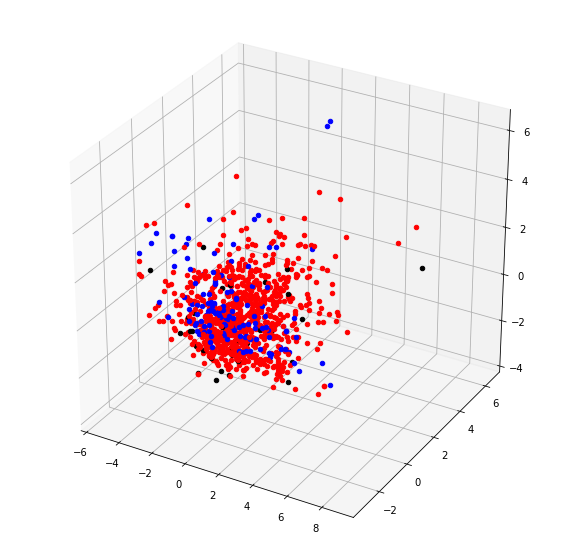

In [140]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection = '3d')
for f in df_to_draw.iterrows():
  ax.scatter(f[1]['pca1'], f[1]['pca2'], f[1]['pca3'], c = colors[int(f[1]['class'])])
  
plt.show()

Явной структуры в данных по методу главных компонент не наблюдается.

Попробуем построить бейзлайн модели.

# **3.Построить и оценить качество бейзлайна**

Подготовим данные для наших классификаторов и разделим данные на тренировочные и тестовые выборки.

In [26]:
ohe = OneHotEncoder()
res = ohe.fit_transform(df_mod['target'].to_numpy().reshape(-1, 1))
ohe_df = pd.DataFrame(res.toarray(), columns = ohe.get_feature_names_out())
ohe_df.describe() 

,x0_bad,x0_good,x0_satisfied
count,1018.000000,1018.000000,1018.000000
mean,0.038310,0.134578,0.827112
std,0.192039,0.341440,0.378336
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


Классификатор для "хорошего" вина:

Разбиваю данные, учитываю их распределение, проверяю распределение данных в выборках

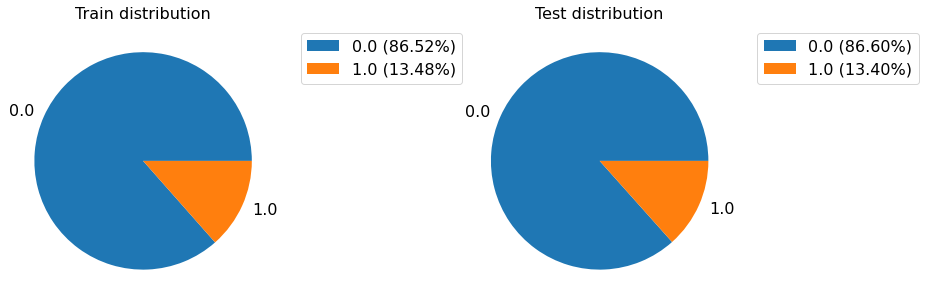

In [27]:
X1 = df_mod_new
#X1 = df_scaled
y1 = ohe_df['x0_good']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=123, test_size=0.3, stratify = y1)

X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.fit_transform(X1_test)

fig, axes = plt.subplots(1, 2, figsize=[15, 5])
axes[0].set_title('Train distribution', fontsize=16)
target_counts = y1_train.value_counts()
axes[0].pie(target_counts, labels=target_counts.index, textprops={'fontsize': 16})
legend_entries = [f'{label} ({count/len(y1_train)*100:.2f}%)' for label, count in target_counts.items()]
axes[0].legend(legend_entries, bbox_to_anchor=(1.05, 1), loc='best', fontsize=16)

axes[1].set_title('Test distribution', fontsize=16)
target_counts = y1_test.value_counts()
axes[1].pie(target_counts, labels=target_counts.index, textprops={'fontsize': 16})
legend_entries = [f'{label} ({count/len(y1_test)*100:.2f}%)' for label, count in target_counts.items()]
axes[1].legend(legend_entries, bbox_to_anchor=(1.05, 1), loc='best', fontsize=16)

Обучаю простые модели

In [28]:
dummy_clf = DummyClassifier(strategy = 'stratified')
dummy_clf.fit(X1_train_scaled, y1_train);

log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(X1_train_scaled, y1_train)

y1_pred_dummy = dummy_clf.predict(X1_test_scaled)
y1_pred_log_reg = log_reg.predict(X1_test_scaled)

Считаю точность и полноту

In [29]:
print(f'Precision for Dummy: {precision_score(y1_test, y1_pred_dummy, zero_division=0)}')
print(f'Precision for Logistic: {precision_score(y1_test, y1_pred_log_reg)}')
print(f'Recall for Dummy: {recall_score(y1_test, y1_pred_dummy, zero_division=0)}')
print(f'Recall for Logistic: {recall_score(y1_test, y1_pred_log_reg)}')

Precision for Dummy: 0.10416666666666667
Precision for Logistic: 0.3645833333333333
Recall for Dummy: 0.12195121951219512
Recall for Logistic: 0.8536585365853658


Считаю F-меры для логической регрессии

In [30]:
f1_score_first = f1_score(y1_test, y1_pred_log_reg)
fbeta_score_first = fbeta_score(y1_test, y1_pred_log_reg, beta = 0.5)
print(f'F1-score for Logistic regression: {f1_score_first}')
print(f'Fbeta-score for Logistic regression: {fbeta_score_first}')

F1-score for Logistic regression: 0.510948905109489
Fbeta-score for Logistic regression: 0.41176470588235287


Пробую проанализировать зависимость от порога бинаризации

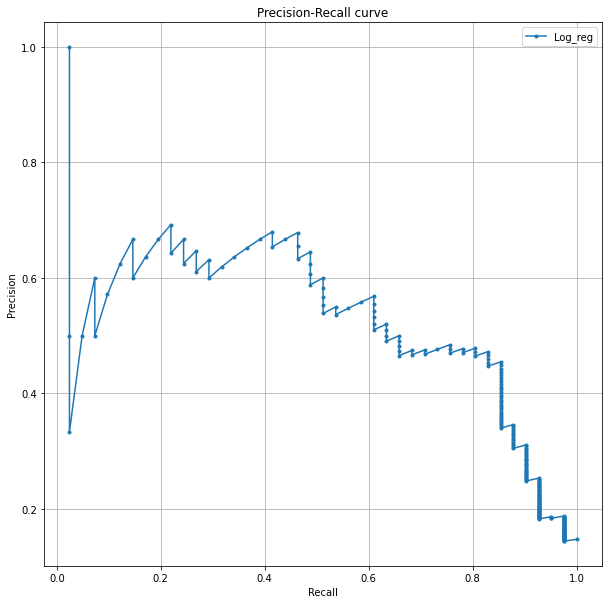

In [31]:
y1_pred = log_reg.predict_proba(X1_test_scaled)[:, 1]
precision, recall, thesholds = precision_recall_curve(y1_test, y1_pred)
plt.figure(figsize=(10,10))
plt.plot(recall[:-1], precision[:-1], marker='.', label='Log_reg')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.grid()
plt.show()

По полученным массивам, пробую предположить, что будет если с Fbeta мерой при фиксации Recall >= 0.8

In [32]:
model_log_data = pd.DataFrame({
    'thesholds': thesholds,
    'precision': precision[:-1],
    'recall': recall[:-1]})
model_log_data = model_log_data[model_log_data.recall >= 0.8]
theshold_opt = model_log_data.thesholds[model_log_data.precision.idxmax()]
recall_opt = model_log_data.recall[model_log_data.precision.idxmax()]
precision_opt = model_log_data.precision[model_log_data.precision.idxmax()]
print(f'Optimized values: {[precision_opt, recall_opt, theshold_opt]}')
fbeta_score_first_opt = (0.5**2 + 1) * (recall_opt * precision_opt) / (recall_opt + 0.5**2 * precision_opt)
print(f'Optimized fbeta_score: {fbeta_score_first_opt}')

Optimized values: [0.4782608695652174, 0.8048780487804879, 0.6537464501345647]
Optimized fbeta_score: 0.5205047318611988


Классификатор для "плохого" вина:

Разбиваю данные, проверяю распределение данных в выборках

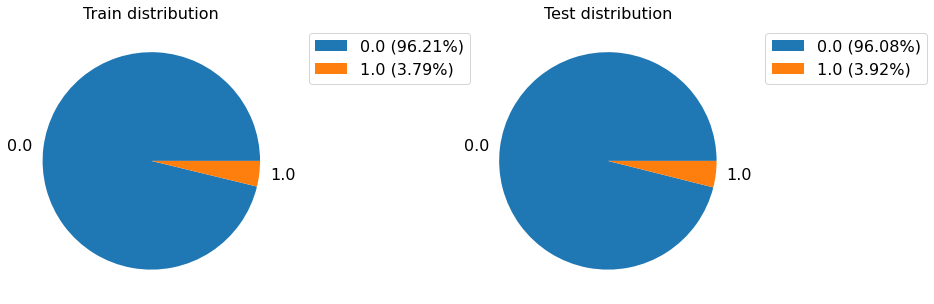

In [33]:
X2 = df_mod_new
#X2 = df_scaled
y2 = ohe_df['x0_bad']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=123, test_size=0.3, stratify = y2)
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.fit_transform(X2_test)
fig, axes = plt.subplots(1, 2, figsize=[15, 5])
axes[0].set_title('Train distribution', fontsize=16)
target_counts = y2_train.value_counts()
axes[0].pie(target_counts, labels=target_counts.index, textprops={'fontsize': 16})
legend_entries = [f'{label} ({count/len(y2_train)*100:.2f}%)' for label, count in target_counts.items()]
axes[0].legend(legend_entries, bbox_to_anchor=(1.05, 1), loc='best', fontsize=16)

axes[1].set_title('Test distribution', fontsize=16)
target_counts = y2_test.value_counts()
axes[1].pie(target_counts, labels=target_counts.index, textprops={'fontsize': 16})
legend_entries = [f'{label} ({count/len(y2_test)*100:.2f}%)' for label, count in target_counts.items()]
axes[1].legend(legend_entries, bbox_to_anchor=(1.05, 1), loc='best', fontsize=16)

Обучаю простые модели

In [34]:
dummy_clf = DummyClassifier(strategy = 'stratified')
dummy_clf.fit(X2_train_scaled, y2_train);

log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(X2_train_scaled, y2_train)

y2_pred_dummy = dummy_clf.predict(X2_test_scaled)
y2_pred_log_reg = log_reg.predict(X2_test_scaled)

Смотрю точность и полноту

In [35]:
print(f'Precision for Dummy: {precision_score(y2_test, y2_pred_dummy, zero_division=0)}')
print(f'Precision for Logistic: {precision_score(y2_test, y2_pred_log_reg)}')
print(f'Recall for Dummy: {recall_score(y2_test, y2_pred_dummy, zero_division=0)}')
print(f'Recall for Logistic: {recall_score(y2_test, y2_pred_log_reg)}')

Precision for Dummy: 0.0
Precision for Logistic: 0.0963855421686747
Recall for Dummy: 0.0
Recall for Logistic: 0.6666666666666666


Считаю F-меры

In [36]:
f1_score_second = f1_score(y2_test, y2_pred_log_reg)
fbeta_score_second = fbeta_score(y2_test, y2_pred_log_reg, beta = 2)
print(f'F1-score for Logistic regression: {f1_score_second}')
print(f'Fbeta-score for Logistic regression: {fbeta_score_second}')

F1-score for Logistic regression: 0.16842105263157894
Fbeta-score for Logistic regression: 0.3053435114503817


Пробую проанализировать зависимость от порога бинаризации

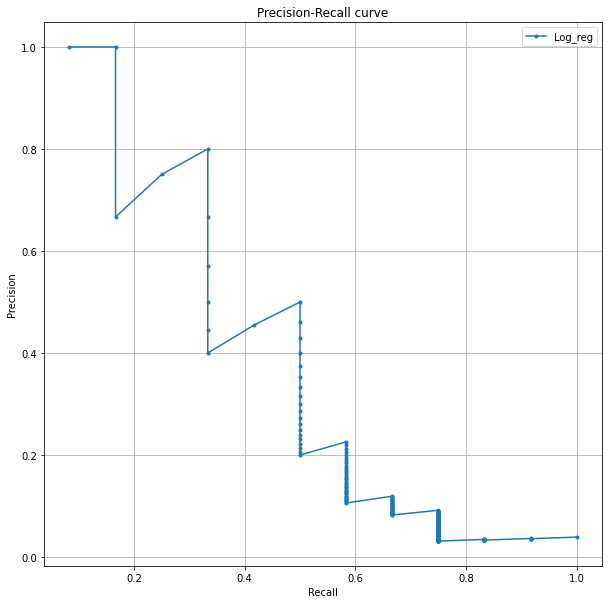

In [37]:
y2_pred = log_reg.predict_proba(X2_test_scaled)[:, 1]
precision, recall, thesholds = precision_recall_curve(y2_test, y2_pred)
plt.figure(figsize=(10,10))
plt.plot(recall[:-1], precision[:-1], marker='.', label='Log_reg')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.grid()
plt.show()

По полученным массивам, пробую предположить, что будет если с Fbeta мерой при фиксации Precision >= 0.67

In [38]:
model_log_data = pd.DataFrame({
    'thesholds': thesholds,
    'precision': precision[:-1],
    'recall': recall[:-1]})
model_log_data = model_log_data[model_log_data.precision >= 0.67]
theshold_opt = model_log_data.thesholds[model_log_data.recall.idxmax()]
recall_opt = model_log_data.recall[model_log_data.recall.idxmax()]
precision_opt = model_log_data.precision[model_log_data.recall.idxmax()]
print(f'Optimized values: {[precision_opt, recall_opt, theshold_opt]}')
fbeta_score_second_opt = (2**2 + 1) * (recall_opt * precision_opt) / (recall_opt + 2**2 * precision_opt)
print(f'Optimized fbeta_score: {fbeta_score_second_opt}')

Optimized values: [0.8, 0.3333333333333333, 0.9123968022614747]
Optimized fbeta_score: 0.3773584905660377


Рассчитываю общую F-меру для бэйзлайна

In [39]:
baseline_score = (fbeta_score_first + fbeta_score_second) / 2
print(f'Quality score for baseline model is: {baseline_score}')
baseline_score_opt = (fbeta_score_first_opt + fbeta_score_second_opt) / 2
print(f'Quality score for baseline model with fixed precision and recall is: {baseline_score_opt}')

Quality score for baseline model is: 0.3585541086663673
Quality score for baseline model with fixed precision and recall is: 0.44893161121361824


# **1. Построить более сложную модель с подбором гиперпараметров**

Попробуем обучить модель случайного леса. 
Построим классификатор для "хорошего" вина


In [40]:
rf = RandomForestClassifier(random_state=123)
rf.fit(X1_train_scaled, y1_train)
y_preds_1 = rf.predict(X1_test_scaled)

Посмотрим точность, полноту и F-меры

In [41]:
print(f'Precision for RF: {precision_score(y1_test, y_preds_1)}')
print(f'Recall for RF: {recall_score(y1_test, y_preds_1)}')
f1_score_rf_first = f1_score(y1_test, y_preds_1)
fbeta_score_rf_first = fbeta_score(y1_test, y_preds_1, beta = 0.5)
print(f'F1-score for RF: {f1_score_rf_first}')
print(f'Fbeta-score for RF: {fbeta_score_rf_first}')

Precision for RF: 0.68
Recall for RF: 0.4146341463414634
F1-score for RF: 0.5151515151515151
Fbeta-score for RF: 0.6028368794326242


Попробуем подобрать гиперпараметры

In [42]:
parameters = {
    'n_estimators': np.arange(50, 250, 25),
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth': list(range(3, 10)) + [None],
    #'min_samples_split': np.arange(2, 10, 2),
    #'class_weight': ["balanced", "balanced_subsample"],
    'max_features': ['sqrt', 'log2', None, 2 , 3, 4],
    'random_state': [123]
}

my_scorer = make_scorer(fbeta_score, beta=0.5)

grid_search = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = parameters,
    n_jobs = 2,
    verbose = 1,
    cv = 5,
    scoring = my_scorer
)

random_search = RandomizedSearchCV(
    estimator = RandomForestClassifier(),
    param_distributions = parameters,
    n_iter = 1000,
    random_state = 1234,
    n_jobs = 4,
    verbose = 1,
    cv = 3,
    scoring = my_scorer
)


In [43]:
#grid_search.fit(X1_train, y1_train)
random_search.fit(X1_train_scaled, y1_train)
#best_parameters = grid_search.best_estimator_.get_params()
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
  print(f"{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
criterion: entropy
max_depth: 7
max_features: 2
n_estimators: 50
random_state: 123


In [44]:
#y_preds_1 = grid_search.best_estimator_.predict(X1_test)
y_preds_1 = random_search.best_estimator_.predict(X1_test_scaled)
print(f'Precision for RF: {precision_score(y1_test, y_preds_1)}')
print(f'Recall for RF: {recall_score(y1_test, y_preds_1)}')
f1_score_rf_first = f1_score(y1_test, y_preds_1)
fbeta_score_rf_first = fbeta_score(y1_test, y_preds_1, beta = 0.5)
print(f'F1-score for RF: {f1_score_rf_first}')
print(f'Fbeta-score for RF: {fbeta_score_rf_first}')

Precision for RF: 0.6190476190476191
Recall for RF: 0.3170731707317073
F1-score for RF: 0.4193548387096774
Fbeta-score for RF: 0.52


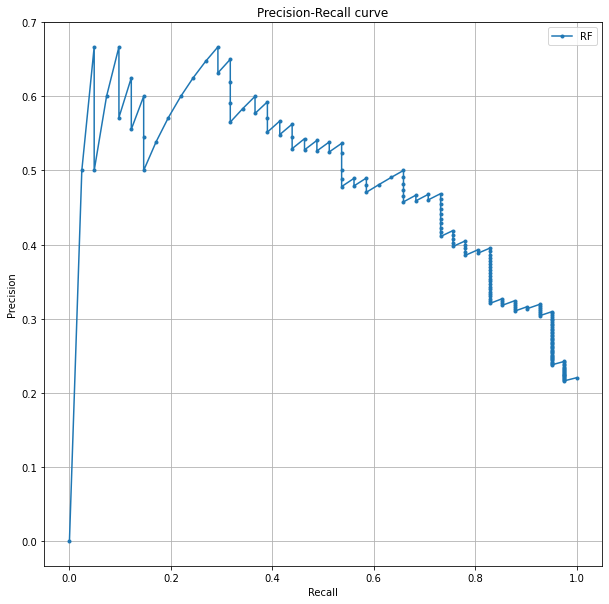

In [45]:
y_preds_1 = random_search.best_estimator_.predict_proba(X1_test_scaled)[:, 1]
precision, recall, thesholds = precision_recall_curve(y1_test, y_preds_1)
plt.figure(figsize=(10,10))
plt.plot(recall[:-1], precision[:-1], marker='.', label='RF')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.grid()
plt.show()

Собственно ничего принципиально хорошего у нас не получилось, попробуем еще градиентный бустинг

In [112]:
my_scorer = make_scorer(fbeta_score, beta=0.5)

parameters = {
    'n_estimators': np.arange(50, 250, 25),
    'max_depth': list(range(3, 10)),
    'booster': ["gbtree", "gblinear", "dart"],
    'seed': [123],
    'learning_rate': np.linspace(0.01, 4, 5),
    'subsample': np.linspace(0.3, 0,9, 5),
    #'colsample_bytree': np.linspace(0.5, 0.98, 5)
    #'reg_alpha': np.arange(1, 10, 0.2)
    #'early_stopping_rounds': list(range(1, 10))
    }


grid_search = GridSearchCV(
    estimator = XGBClassifier(),
    param_grid = parameters,
    n_jobs = 2,
    verbose = 1,
    cv = 5,
    scoring = my_scorer
)

random_search = RandomizedSearchCV(
    estimator = XGBClassifier(),
    param_distributions = parameters,
    n_iter = 500,
    random_state = 1234,
    n_jobs = 5,
    verbose = 1,
    cv = 5,
    scoring = my_scorer
)

In [113]:
#grid_search.fit(X1_train, y1_train)
random_search.fit(X1_train_scaled, y1_train)
#best_parameters = grid_search.best_estimator_.get_params()
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
  print(f"{param_name}: {best_parameters[param_name]}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
booster: gbtree
learning_rate: 0.01
max_depth: 8
n_estimators: 200
seed: 123
subsample: 0.22499999999999998


In [114]:
#y_preds_1 = grid_search.best_estimator_.predict(X1_test)
y_preds_1 = random_search.best_estimator_.predict(X1_test_scaled)
print(f'Precision for RGB: {precision_score(y1_test, y_preds_1)}')
print(f'Recall for RGB: {recall_score(y1_test, y_preds_1)}')
f1_score_rf_first = f1_score(y1_test, y_preds_1)
fbeta_score_rf_first = fbeta_score(y1_test, y_preds_1, beta = 0.5)
print(f'F1-score for RGB: {f1_score_rf_first}')
print(f'Fbeta-score for RGB: {fbeta_score_rf_first}')

Precision for RGB: 0.6086956521739131
Recall for RGB: 0.34146341463414637
F1-score for RGB: 0.4375
Fbeta-score for RGB: 0.5263157894736843


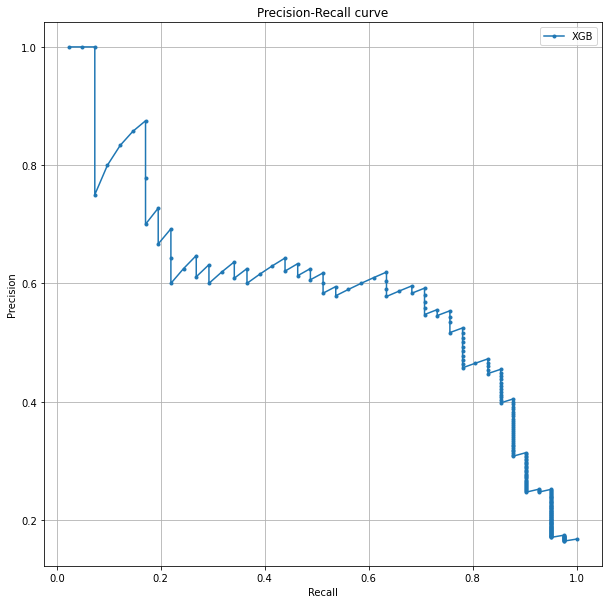

In [115]:
y_preds_1 = random_search.best_estimator_.predict_proba(X1_test_scaled)[:, 1]
precision, recall, thesholds = precision_recall_curve(y1_test, y_preds_1)
plt.figure(figsize=(10,10))
plt.plot(recall[:-1], precision[:-1], marker='.', label='XGB')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.grid()
plt.show()

Принципиально лучших результатов мы не получили, но надо идти дальше.
Оценим Fbeta меру при условии ограничения recall >= 0.8

In [116]:
model_XGB_data = pd.DataFrame({
    'thesholds': thesholds,
    'precision': precision[:-1],
    'recall': recall[:-1]})
model_XGB_data = model_XGB_data[model_XGB_data.recall >= 0.8]
theshold_opt = model_XGB_data.thesholds[model_XGB_data.precision.idxmax()]
recall_opt = model_XGB_data.recall[model_XGB_data.precision.idxmax()]
precision_opt = model_XGB_data.precision[model_XGB_data.precision.idxmax()]
print(f'Optimized values: {[precision_opt, recall_opt, theshold_opt]}')
fbeta_score_1_opt_xgb = (0.5**2 + 1) * (recall_opt * precision_opt) / (recall_opt + 0.5**2 * precision_opt)
print(f'Optimized fbeta_score: {fbeta_score_1_opt_xgb}')

Optimized values: [0.4722222222222222, 0.8292682926829268, 0.25230968]
Optimized fbeta_score: 0.5167173252279634


Посмотрим классификатор для "плохого" вина.

Ограничимся случайным лесом.

In [100]:
my_scorer_2 = make_scorer(fbeta_score, beta=2)

parameters = {
    'n_estimators': np.arange(50, 250, 25),
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth': list(range(3, 10)) + [None],
    'min_samples_split': np.arange(2, 10, 2),
    'class_weight': ["balanced", "balanced_subsample"],
    'max_features': ['sqrt', 'log2', None, 2 , 3, 4, 6, 8, 10, 11],
    'random_state': [123]
}

grid_search = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = parameters,
    n_jobs = 2,
    verbose = 1,
    cv = 5,
    scoring = my_scorer_2
)

random_search2 = RandomizedSearchCV(
    estimator = RandomForestClassifier(),
    param_distributions = parameters,
    n_iter = 1000,
    random_state = 1234,
    n_jobs = 4,
    verbose = 1,
    cv = 3,
    scoring = my_scorer_2
)

In [102]:
#grid_search.fit(X1_train, y1_train)
random_search2.fit(X2_train_scaled, y2_train)
#best_parameters = grid_search.best_estimator_.get_params()
best_parameters = random_search2.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
  print(f"{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
class_weight: balanced_subsample
criterion: entropy
max_depth: 3
max_features: log2
min_samples_split: 6
n_estimators: 100
random_state: 123


In [108]:
#y_preds_1 = grid_search.best_estimator_.predict(X1_test)
y_preds_2 = random_search2.best_estimator_.predict(X2_test_scaled)
print(f'Precision for RF: {precision_score(y2_test, y_preds_2)}')
print(f'Recall for RF: {recall_score(y2_test, y_preds_2)}')
f1_score_rf_second = f1_score(y2_test, y_preds_2)
fbeta_score_rf_second = fbeta_score(y2_test, y_preds_2, beta = 2)
print(f'F1-score for RF: {f1_score_rf_second}')
print(f'Fbeta-score for RF: {fbeta_score_rf_second}')
#y_preds_2

Precision for RF: 0.13043478260869565
Recall for RF: 0.25
F1-score for RF: 0.1714285714285714
Fbeta-score for RF: 0.2112676056338028


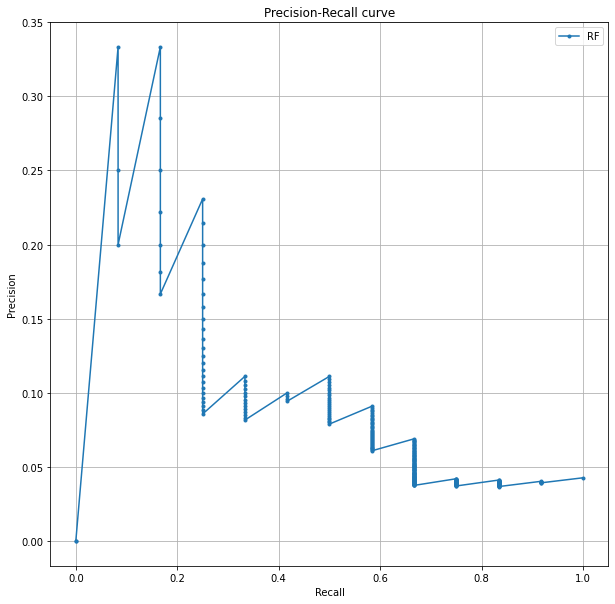

In [109]:
y_preds_2 = random_search2.best_estimator_.predict_proba(X2_test_scaled)[:, 1]
precision, recall, thesholds = precision_recall_curve(y2_test, y_preds_2)
plt.figure(figsize=(10,10))
plt.plot(recall[:-1], precision[:-1], marker='.', label='RF')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.grid()
plt.show()

Такой классификатор не дает даже задать границу по точности. 

Кажется, такое ансамблирование на нашей выборке с несбалансированными классами и малым количеством примеров не дает результатов.

Наверное нужно пробовать другие методы. Но время на задание заканчивается. Порефлексирую на эту тему в конце ноутбука :)

# **2. Проинтерпретировать полученную модель** 

Попробуем методы интерпретации на примере классификатора для "хорошего вина"

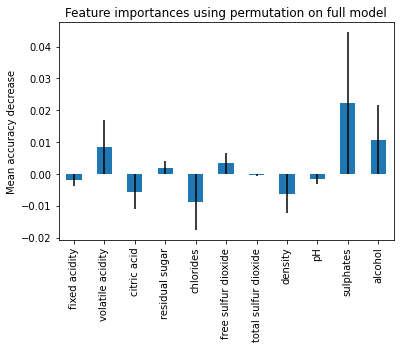

In [120]:
my_model = random_search.best_estimator_
importances = permutation_importance(my_model, X1_test_scaled, y1_test, n_repeats = 10, random_state=2023, n_jobs = 2)
my_model_importances = pd.Series(importances.importances_mean, index = X1_train.columns)

fig, ax = plt.subplots()
my_model_importances.plot.bar(yerr=importances.importances_mean, ax = ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
plt.show()

Судя по всему наша модель воспринимает признаки "Сульфаты" и "Алкоголь" как определяющие. В сети мало информации про использование СульфАтов в виноделии. Возможно их используют как консерванты вместо диоксида серы ( который - сульфИт). Вроде как это вреднее, но модель считает, что вкуснее:)

Про "Алкоголь" уже писал. Корреляцию видно уже из анализа данных.

Попробуем инструмент библиотеки Shap и будет заканчивать на сегодня.

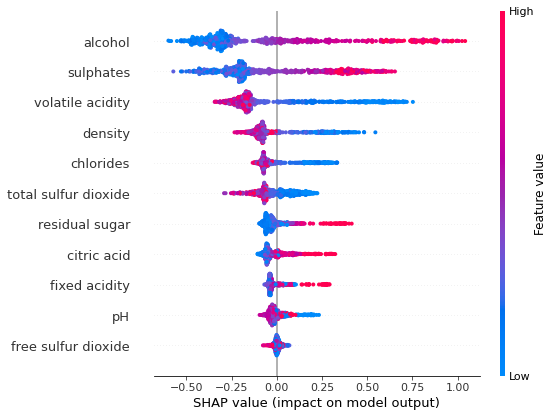

In [145]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(X1_train_scaled)
shap.summary_plot(shap_values, X1_train_scaled, feature_names = features)

Красивая и доступная картинка. Подтверждает тезисы про Алкоголь и Летучую кислотность, которые были видны из корреляции. Сульфаты тоже, кстати, видны из корреляционной матрицы. 

Можно даже составить рецепт "хорошего" вина (по мнению моей модели).

# **Рефлексия**
**По проекту:**

Достичь сколько-нибудь хорошего качества опробованными методами не удалось.

При подоборе гипермапараметров конечно не хватало знания математики алгоритмов. Сидишь, смотришь на два десятка параметров и не понимаешь в каких диапазонах значений они обычно могут находиться, а простой поиск по сетке занимает много времени, но это издержки моего уровня знаний и направленности курса на "быстрый вход".

Курс заканчивается, поэтому просто поставлю задачи на будущую свободную возню с датасетом.

Что можно попробовать:

Заняться feature engeneering ом:
- поработать с выбросами
- поработать с распределением
- убрать признаки или сформировать новые, искуственные признаки

Попробовать поработать с мультиклассовой классификацией, возможно не стоит объединять вино с оценками 5 и 6 в один большой класс.

Скорректировать дисбаланс классов: возможно добавить искуственные сэмплы

Попробовать другой класс моделей, например нейронные сети

По курсу:

Почему курс понравился:
1. Удается начать что-то делать не закопавшись в математике алгоритмов ML
2. Познакомили и "заставили" начать работать с инструментами сопустствующими разработке: Colab, Git. Узнал много интересного из лекции про вопроизводимость исследований.
3. Наполнение лекций - кайф. Особенно для ознакомительного курса. Дает нужные точки для поиска по документации.

Что не понравилось: 
1. Продолжительность курса.

Новичку очень сложно начать "итоговый" проект не потренировавшись на каких-то типовых заданиях. Я пару вечеров только прокрастинировал над датасетами в Kaggle:) Но возможно это моя проблема.

Можно ли будет к вам обратиться если возникнут вопросы по поиску дополнительных учебных материалов по некоторым темам?

Надеюсь, что в следующем семестре будет перезапуск курса и можно будет пройти "продвинутый" трек.

Огромное вам спасибо, что несете ML в массы!